In [1]:
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
import matplotlib

In [3]:
pass

In [4]:
matplotlib.rcParams['figure.figsize'] = [14, 12]

In [5]:
import glob
import os

In [6]:
data_dir = 'data/carla_sequence_00/'
names = sorted([os.path.basename(i) for i in glob.glob(data_dir+'left/*')])
print(names)

['427268.4066.png', '427269.5126.png', '427270.6023.png', '427271.6985.png', '427272.8063.png', '427273.9091.png', '427274.9405.png', '427275.9621.png', '427277.0102.png', '427278.1275.png', '427279.2663.png', '427280.3944.png', '427281.4921.png', '427282.5857.png', '427283.6848.png', '427284.7835.png', '427285.8763.png', '427286.9291.png', '427287.9109.png', '427288.9013.png', '427289.9378.png', '427291.0055.png', '427292.0810.png', '427293.1672.png', '427294.2754.png', '427295.3922.png']


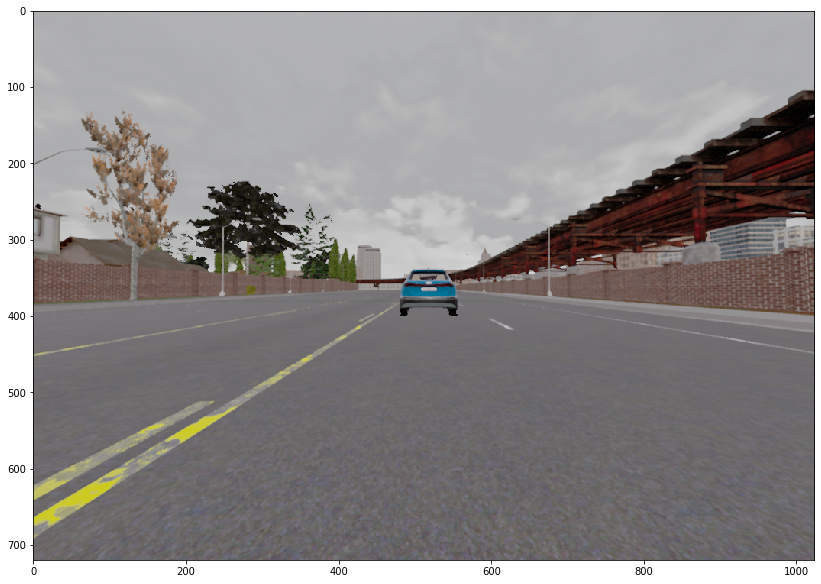

In [7]:
for name in names:
    left = cv.imread(data_dir+'left/'+name)
    left = cv.cvtColor(left, cv.COLOR_BGR2RGB)
    plt.imshow(left)
    break

In [9]:
from detector import Detector

In [18]:
from utils import *

In [30]:
# %load cadar.py
import cv2 as cv
import numpy as np
from object_pool import ObjectPool


class CADAR:
    def __init__(self):
        self.last_img = None
        self.tracker = cv.TrackerKCF_create()
        self.detector = Detector()
        self.objects = ObjectPool()
        self.reconstructor = cv.StereoSGBM_create()
        self.velocity = 0.0

    def push(self, img):
        self.last_img = img
        if len(self.objects) != 0:
            success, boxes = self.tracker.update(self.last_img)
            (x, y, w, h) = [int(v) for v in boxes]

        for (box, label, score) in detect(img):
            self.objects.append(DetectedObject(box, label, score))

    def viz(self):
        viz = self.last_img.copy()
        for obj in self.objects.get_objects():
#             print(obj.box, obj.label, obj.score)
            print((obj.box[0], obj.box[1]), (obj.box[2], obj.box[3]), (0, 255, 0), 2)
            cv.rectangle(viz, (obj.box[0], obj.box[1]), (obj.box[2], obj.box[3]), (0, 255, 0), 2)
            cv.putText(viz, obj.label, (obj.box[0], obj.box[1]), 0, 1, (0, 255, 0), 2)
            # cv.putText(viz, label+str(dist)+' m.', tuple(lu.astype(np.int32)), 0, 1, (0, 255, 0), 2)
        return viz

In [31]:
cadar = CADAR()

In [ ]:
for i, name in enumerate(names):
    print(i)
    if i > 13:
        break
    left = cv.imread(data_dir+'left/'+name)
    right = cv.imread(data_dir+'right/'+name)
    depth = cv.imread(data_dir+'depth/'+name)
    
#     objects = detect(left)
#     print(objects)
    cadar.push(left)
    
#     plt.imshow(np.hstack((left, right, depth)))
    plt.imshow(cv.cvtColor(cadar.viz(), cv.COLOR_BGR2RGB))
    plt.show()

In [7]:
from IPython.display import HTML
import numpy as np
import matplotlib.animation as animation

out = cv.VideoWriter('out.webm',cv.VideoWriter_fourcc(*'VP80'), 1, (1024, 720))

sgbm = cv.StereoSGBM_create(
    numDisparities=128, blockSize=5,
    P1=64, P2=256,
    mode=cv.StereoSGBM_MODE_SGBM_3WAY)


B, F, cx, cy = 0.3, 720, 1024 // 2, 720 // 2

Q = np.array([
    [1, 0, 0, -cx],
    [0, 1, 0, -cy],
    [0, 0, 0, F],
    [0, 0, -1/B, 0],
])

with torch.no_grad():
    for name in names:
        left = cv.imread(data_dir+'left/'+name)
        right = cv.imread(data_dir+'right/'+name)
        depth = cv.imread(data_dir+'depth/'+name)

        disp = sgbm.compute(left, right) / 16.0
        XYZ = cv.reprojectImageTo3D(disp.astype(np.float32), Q) * -1
        X, Y, Z = XYZ[...,0], XYZ[...,1], XYZ[...,2]
        Z[np.where(Z > 100)] = 100
        Z[np.where(Z < 0)] = 1000

        transform = T.Compose([
            T.ToPILImage(),
            T.ToTensor()
        ])
        tensor = transform(cv.cvtColor(left, cv.COLOR_BGR2RGB)).cuda()
        detected = faster_rcnn([tensor])[0]
        boxes = detected['boxes'].cpu().numpy()
        labels = detected['labels'].cpu().numpy()
        scores = detected['scores'].cpu().numpy()

        for box, label, score in zip(boxes, labels, scores):
            if score > 0.5 and label in [2, 3, 4, 6, 8]:
                print(score)
                label = 'car'
                lu = box[:2]
                rb = box[2:]
                
                w, h = rb - lu
                lu += w/4, h/4
                rb -= w/4, h/4
                lu = tuple(lu.astype(np.int32))
                rb = tuple(rb.astype(np.int32))
                print(lu, rb)
                
                box = box.astype(np.int32)
                
                dist = int(Z[lu[1]:rb[1], lu[0]:rb[0]].min())
                print(dist)
                cv.rectangle(left, tuple(lu.astype(np.int32)), tuple(rb.astype(np.int32)), (0, 255, 0), 2)
                cv.putText(left, label+str(dist)+' m.', tuple(lu.astype(np.int32)), 0, 1, (0, 255, 0), 2)
                
#                 cv.rectangle(left, lu, rb, (0, 255, 0), 2)
#                 cv.putText(left, label+str(dist)+' m.', lu, 0, 1, (0, 255, 0), 2)
        plt.imshow(left)
    
        out.write(left)
#     break


0.8087086
(497, 354) (539, 378)
16


AttributeError: 'tuple' object has no attribute 'astype'

<video src='out.webm'  width=480  autoplay controls/>

# 